# Naive Bayes Classifier

Bayesian classification methods rely on Baye's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities. In Bayesian classification, we're interested in finding the probability of a label given some observed features, which can be written as: **P(L | features)**. Bayes theorem tells us how to express this in terms of quantities we can compute more directly: **P(L | features) = (P(features | L) * P(L)) / P(features)**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Gaussian Naive Bayes
Perhaps the easiest naive Bayes classifier to understand is Gaussian naive Bayes. In this classifier, the assumption is that *data from each label is drawn from a simple Gaussian distribution*. Imagine the following data:

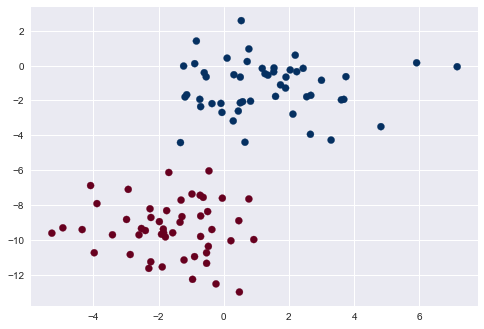

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

One extremely fast way to create a simple model is to assume that the data is described by a Gaussian distribution with no covariance between dimensions. We can fit this model by simple finding the mean and standard deviation of the points within each label.

With this model in place for each class, we have a simple recipe to compute the likelihood **P(features | $L_1$)** for any data point and we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

In [3]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

In [4]:
# generate some new data and predict label
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

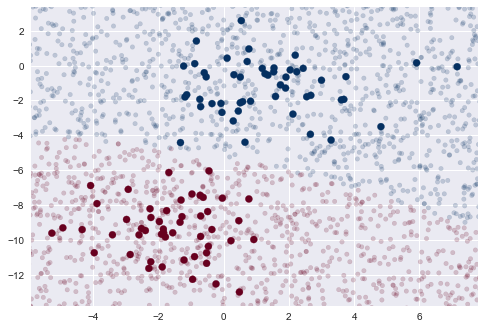

In [10]:
# Plot data to get an idea of decision boundary
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.2)
plt.axis(lim);

We see a slightly curved boundary in the classifications - in general, the boundary in Gaussian naive Bayes is quadratic.

A nice piece of this Bayesian formalism is that is allows for probabilistic classification, which we can compute using the **`predict_proba`** method:

In [11]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[ 0.89,  0.11],
       [ 1.  ,  0.  ],
       [ 1.  ,  0.  ],
       [ 1.  ,  0.  ],
       [ 1.  ,  0.  ],
       [ 1.  ,  0.  ],
       [ 0.  ,  1.  ],
       [ 0.15,  0.85]])

The columns give the probability of the first and second label, respectively. This is a useful approach for looking for estimates of uncertainty in your classification. 

The final model is only as good as the model assumptions that lead to it, so the Gaussian naive Bayes often does not produce very good results. Still, in many cases - especially as the number of features becomes large - this assumption is not detrimental enough to prevent Gaussian naive Bayes from being a useful method.

## Multinomial Naive Bayes

Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution. The multinomial distribution describes the probability of observing counts among a number of categories, and this multinomial naive Bayes is most appropriate for features that represent counts or count rates. This is the same as above, except instead of modeling the data distribution with the best-fit Gaussian, we model it with a best-fit multinomial distribution.

#### Example: Classifying text

Here we will use the sparse word count features from the 20 Newsgroups corpus to show how we might classify these short documents into categories.

In [12]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups()
data.target_names

No handlers could be found for logger "sklearn.datasets.twenty_newsgroups"


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [13]:
categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [16]:
# let's view one of the entries
print train.data[5]

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers. We will use the TF-IDF vectorizer and create a pipeline that attaches it to a multinomial naive Bayes classifier:

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [20]:
# Apply the model to the training data
model.fit(train.data, train.target)

# Make predictions
labels = model.predict(test.data)

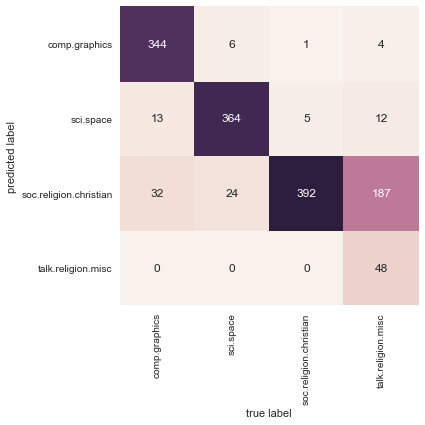

In [21]:
# evaluate performance
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels = train.target_names, yticklabels = train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

Looks like the model successfully separated space talk from computer talk, but got confused between talk about religion and talk about Christianity, which is understandable. 

Here is a quick utility function that will return the prediction for a single string:

In [22]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [23]:
predict_category('sending a payload to the ISS')

'sci.space'

In [24]:
predict_category('Jesus will not be happy about your abortion')

'soc.religion.christian'

In [26]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [27]:
predict_category('determining the screen resolution')

'comp.graphics'

## When to Use Naive Bayes
Because naive Bayesian classifiers make such stringent assumptions about data, they will generally not perform as well as a more complicated model. That said, they have several advantages:
 - They are extremely fast for both training and prediction
 - They provide straightforward probabilistic prediction
 - They are often very easily interpretable
 - They have very few (if any) tunable parameters
 
A naive Bayesian classifier is often a good choice as an intial baseline classification, and tend to perform especially well in one of the following situations:
 - When the naive assumptions actually match the data (very rare in practice)
 - For very well-separated categories, when model complexity is less important
 - For very high-dimensional data, when model complexity is less important